# CS Career Survey

(Data Found Here: https://docs.google.com/spreadsheets/d/1NZLCpnaaKCMIb0OrKElEOcuuCKbG4zUggy2PNgJnYys/edit)

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# Format floats without scientific notation
pd.set_option('display.float_format', lambda x: '%.3f' % x)

data = pd.read_csv("../data/cscareerquestions.csv")

## Preprocessing

In [2]:
data.describe()

,"What is your base hourly rate? (If the number changes regularly, pick a value that best represents the average rate.)",In the average week how many hours do you work for your base hourly rate?,What is your gross annualized base pay? (Multiply your monthly pay by 12.),Non-compensated overtime? In the average week how many overtime hours (after 40 hrs/wk) do you work WITHOUT any additional compensation?,"What is your overtime (after 40 hrs/wk) hourly rate? (If the number changes regularly, pick a value that best represents the average rate.)",In the average week how many hours do you work for your overtime (after 40 hrs/wk) rate?,Did you receive a signing bonus when you joined your current employer? Please provide the amount you received.,"Do you receive a yearly bonus? If so, please provide your best estimate of it for an average year.","Do you receive a monthly housing stipend or free corporate housing? Please provide the monthly value of the free housing or the monthly stipend amount. (For lump sum housing stipends, divide the total by the number of months covered.)",Do you receive any company equity? What is the approximate value of the equity you receive?,...,"In minutes, how long is the average commute one way? (If you live and work in the same building, 0 is a sufficient answer.)",How many hours do you work in a normal week?,"How many sick days are you allowed per year? (Use -1 if your employer allows for ""infinite"" sick days.)","How many discretionary vacation days are you allowed per year? (Use -1 if your employer allows for ""infinite"" discretionary vacation days.)","For how many days in an average year does the office ""close"" due to a holiday?","How many days out of the year do you expect to be in ""crunch time""?",How many days out of the year do you expect to be on-call?,"In the average year, how many nights, weekends or vacation/holiday days do you anticipate needing to do any work at all?",How old are you?,"Cost of living plus rent index number (For example, San Francisco is 110.58)"
count,143.000,143.000,1036.000,895.000,167.000,167.000,754.000,763.000,313.000,533.000,...,1011.000,1012.000,926.000,951.000,903.000,758.000,706.000,601.000,1084.000,887.000
mean,30.180,35.797,1136926.438,2.713,45.991,2.198,7695.643,12640.702,352.354,46920.906,...,25.533,40.291,3.979,13.298,9.325,25.896,42.851,13.259,26.416,76.516
std,18.215,9.502,23209996.491,6.833,92.269,5.928,22887.308,84618.145,1267.315,107240.348,...,21.039,6.729,12.293,10.087,5.199,49.951,100.298,38.150,5.115,87.244
min,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,-1.000,-1.000,0.000,0.000,0.000,0.000,10.000,-1.000
25%,20.000,37.500,63000.000,0.000,21.750,0.000,0.000,0.000,0.000,0.000,...,10.000,40.000,-1.000,10.000,7.000,0.000,0.000,0.000,23.000,56.000
50%,26.000,40.000,84500.000,0.000,35.000,0.000,0.000,3000.000,0.000,1000.000,...,20.000,40.000,0.000,15.000,9.000,14.000,0.000,2.000,25.000,70.950
75%,35.575,40.000,112000.000,4.000,50.000,2.000,8750.000,10000.000,0.000,53000.000,...,35.000,42.000,5.000,20.000,11.000,30.000,30.000,10.000,29.000,83.000
max,125.000,60.000,555555456.000,76.000,900.000,40.000,450000.000,2025000.000,10000.000,1500000.000,...,180.000,70.000,180.000,120.000,88.000,365.000,365.000,365.000,51.000,1940.000


In [3]:
# rename some columns, since survey questions make crappy column names
data = data.rename(columns = {'Choose the option that best fits your job type.': 'job_type'})
data = data.rename(columns = {'What is your job title?':'job_title'})
data = data.rename(columns = {'Choose the option that bests fits your job title.':'job_title_best_fit'})
data = data.rename(columns = {'Is this a remote position?':'remote'})
data = data.rename(columns = {'Company name?':'company_name'})
data = data.rename(columns = {'Company purpose/Industry?':'company_industry'})
data = data.rename(columns = {'How much cumulative work experience do you have across all jobs held (even those not relevant to Computer Science)?':'all_experience'})
data = data.rename(columns = {'How much cumulative work experience do you have that is relevant to Computer Science? (use your best judgment for whether certain positions were relevant)':'cs_experience'})
data = data.rename(columns = {'How long have you worked for your current employer?':'worked_current_employer'})
data = data.rename(columns = {'How long have you held your current position?':'worked_current_position'})
# Please provide any context about your employment track. Did you work in a different field, before? Have you worked your way up in one company or job hopped a bunch? Any and all details are appreciated.'
data = data.rename(columns = {'Are you currently enrolled in some form of school? Please select the option that best matches your stage of current enrollment. (If you are between terms select the option that best matches the term you will begin in the near future.)':'enrolled_in_school'})
# ... rename columns later
data = data.rename(columns = {'Which currency will your compensation be represented in?':'currency_unit'})
data = data.rename(columns = {'What is your base hourly rate? (If the number changes regularly, pick a value that best represents the average rate.)':'base_hourly_rate'})
data = data.rename(columns = {'In the average week how many hours do you work for your base hourly rate?':'hours_for_base_hourly_rate'})
data = data.rename(columns = {'What is your gross annualized base pay? (Multiply your monthly pay by 12.)':'gross_annualized_base_pay'})
data = data.rename(columns = {'Gender':'gender'})

data.columns

Index(['Timestamp', 'job_type', 'job_title', 'job_title_best_fit', 'remote',
       'company_name', 'company_industry', 'all_experience', 'cs_experience',
       'worked_current_employer', 'worked_current_position',
       'Please provide any context about your employment track. Did you work in a different field, before? Have you worked your way up in one company or job hopped a bunch? Any and all details are appreciated.',
       'enrolled_in_school',
       'What is the major or concentration of your current enrollment?',
       'Choose the option that best matches the major or concentration of your current enrollment.',
       'Have you graduated or completed any form of education already? Select the option that best matches your highest level of completed education.',
       'What was the major or concentration of your highest level of completed education?',
       'Choose the option that best matches the major or concentration of your highest level of completed education.',
      

In [4]:
## Calculate pay metrics

# grab not null values of hourly pay
pay_not_null = data.base_hourly_rate[data['base_hourly_rate'].notnull()]
hours_not_null = data.hours_for_base_hourly_rate[data['hours_for_base_hourly_rate'].notnull()]
base_hourly = pd.concat([pay_not_null, hours_not_null], join='outer', axis=1)

# Select only full-time
base_hourly = base_hourly[base_hourly.hours_for_base_hourly_rate >= 35]

# calculate yearly salary
base_hourly['base_yearly_rate'] = (base_hourly['base_hourly_rate'] * base_hourly['hours_for_base_hourly_rate']) * 52

# grab salaried employees
salary_not_null = data.gross_annualized_base_pay[data['gross_annualized_base_pay'].notnull()]

# join with hourly employees
base = pd.concat([base_hourly, salary_not_null], join='outer', axis=1)
base_salary = base['base_yearly_rate'].fillna(base.gross_annualized_base_pay).to_frame()
base_salary = base_salary.rename(columns = {'base_yearly_rate':'base_salary'})

# add best fit job titles, experience, and denomination to salary
base_salary = pd.concat([data.job_title_best_fit, data.all_experience, data.cs_experience, base_salary, data.currency_unit], join='inner', axis=1)

# Convert '4yr 6mo' type string to int
base_salary.all_experience = base_salary.all_experience.str.split(" ").str.get(0).str.extract('(\d+)', expand=False).astype(int) + (base_salary.all_experience.str.split(" ").str.get(1).str.extract('(\d+)', expand=False)).astype(int) / 12
base_salary.cs_experience = base_salary.cs_experience.str.split(" ").str.get(0).str.extract('(\d+)', expand=False).astype(int) + (base_salary.cs_experience.str.split(" ").str.get(1).str.extract('(\d+)', expand=False)).astype(int) / 12

# Remove Salaries not in 'USD - $'
base_salary = base_salary[base_salary.currency_unit == 'USD - $']

# remove salaries above 1 million and below 15,600 (minimum wage in USA) because they are shifting data in unrealistic ways
base_salary = base_salary[(base_salary.base_salary <= 1000000) & (base_salary.base_salary >= 15600)]

# Remove Outliers (keep salaries between -3sigma and +3 sigma, assumes normal)
base_salary = base_salary[np.abs(base_salary.base_salary-base_salary.base_salary.mean())<=(3*base_salary.base_salary.std())]

base_salary.head()

,job_title_best_fit,all_experience,cs_experience,base_salary,currency_unit
0,Developer/Engineering Generalist,0.500,0.500,84000.000,USD - $
1,Developer/Engineering Generalist,6.000,5.000,130000.000,USD - $
2,Developer/Engineering Generalist,7.000,2.500,108000.000,USD - $
3,Systems Administrator (SysAdmin),2.000,2.000,45760.000,USD - $
4,Mobile app developer/Mobile app engineer,4.500,3.667,75000.000,USD - $


# Visualization

In [5]:
# pay by job title

base_salary.groupby(['job_title_best_fit'])['base_salary'].mean().sort_values(ascending=False)

job_title_best_fit
Engineering manager                             153100.000
Technology Evangelist                           150000.000
Project/Product/Program manager                 120250.000
Mobile OS developer/Mobile OS engineer          118560.000
Desktop OS developer/Desktop OS engineer        117000.000
Software Architect                              114488.889
Sales engineer                                  109500.000
Big data engineer                               105595.478
Data scientist                                  103705.000
Back-end web developer/Back-end engineer        102819.193
Developer in test/tools for hardware products   101021.000
Security Engineer                                97334.250
Systems Software Engineer                        96963.254
Developer/Engineering Generalist                 92328.466
Developer in test/tools for software products    89953.125
Mobile app developer/Mobile app engineer         89492.229
Developer Operations (DevOps)        

/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


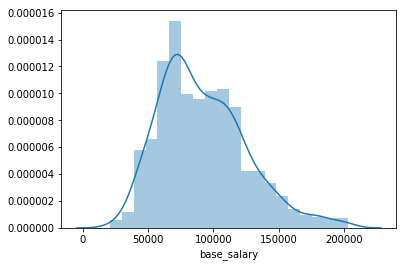

In [6]:
sns.distplot(base_salary.base_salary)

In [7]:
base_salary.base_salary.mean()

91720.3976400862

### Experience

/usr/local/lib/python3.7/site-packages/seaborn/regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


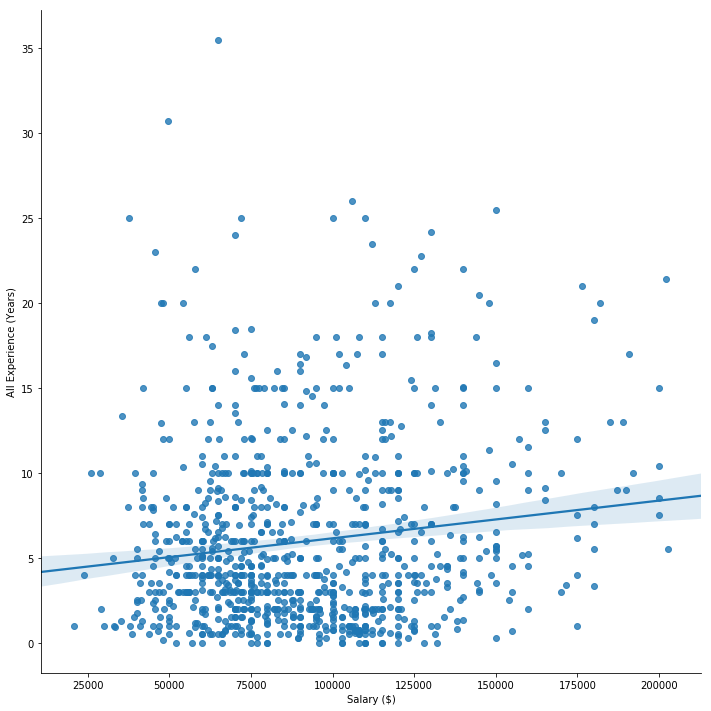

In [8]:
g = sns.lmplot(x="base_salary", y="all_experience",
               truncate=False, size=10, data=base_salary)

g.set_axis_labels("Salary ($)", "All Experience (Years)")

/usr/local/lib/python3.7/site-packages/seaborn/regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


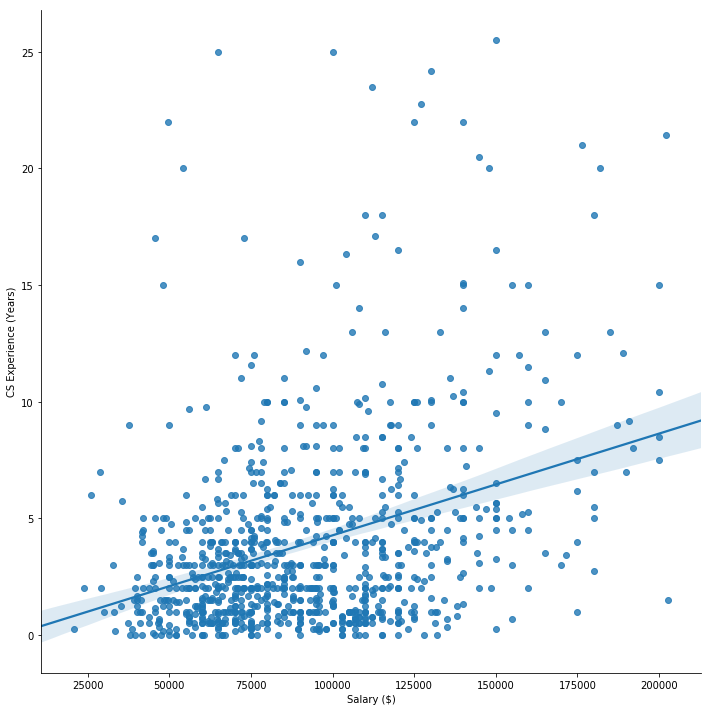

In [9]:
g = sns.lmplot(x="base_salary", y="cs_experience",
               truncate=False, size=10, data=base_salary)

g.set_axis_labels("Salary ($)", "CS Experience (Years)")

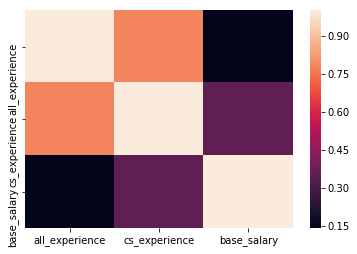

In [10]:
corr = base_salary.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

The mean of all people who responded to the survey is ~92k and in general, we can see managers of engineers make more than engineers. As for experience, we see that All Experience has essentially no influence on salary, while CS Experience has a little influence, but not that much -  Goes to show that not just any experience, but applicable experience influences salary.

### Manager Role

In [11]:
# Add manager column

base_salary['manager'] = False

base_salary['manager'][(base_salary.job_title_best_fit == 'Technology Evangelist')
                      | (base_salary.job_title_best_fit == 'Engineering manager')
                      | (base_salary.job_title_best_fit == 'Project/Product/Program manager')
                      | (base_salary.job_title_best_fit == 'Software Architect')] = True

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


/usr/local/lib/python3.7/site-packages/seaborn/regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


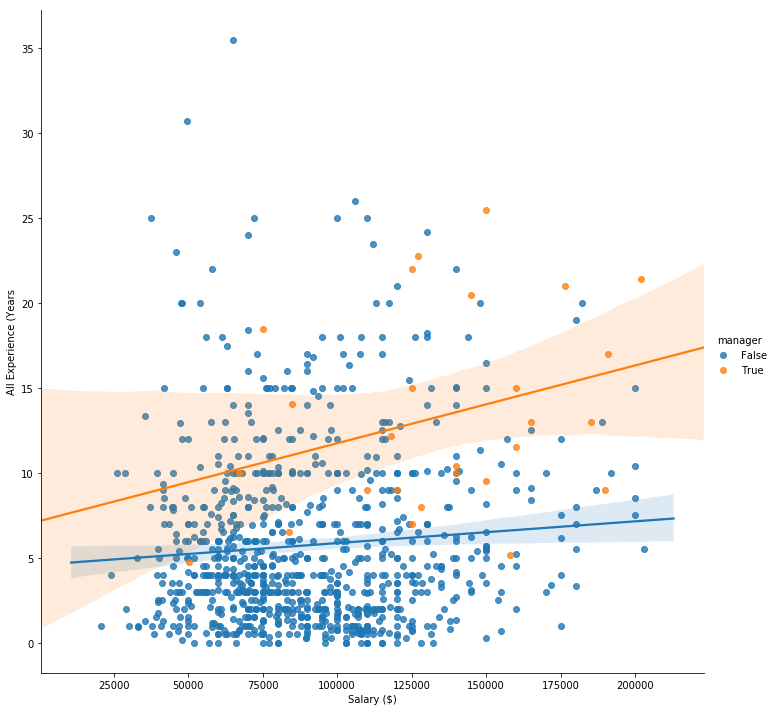

In [12]:
g = sns.lmplot(x="base_salary", y="all_experience", hue="manager",
               truncate=False, size=10, data=base_salary)

g.set_axis_labels("Salary ($)", "All Experience (Years")

/usr/local/lib/python3.7/site-packages/seaborn/regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


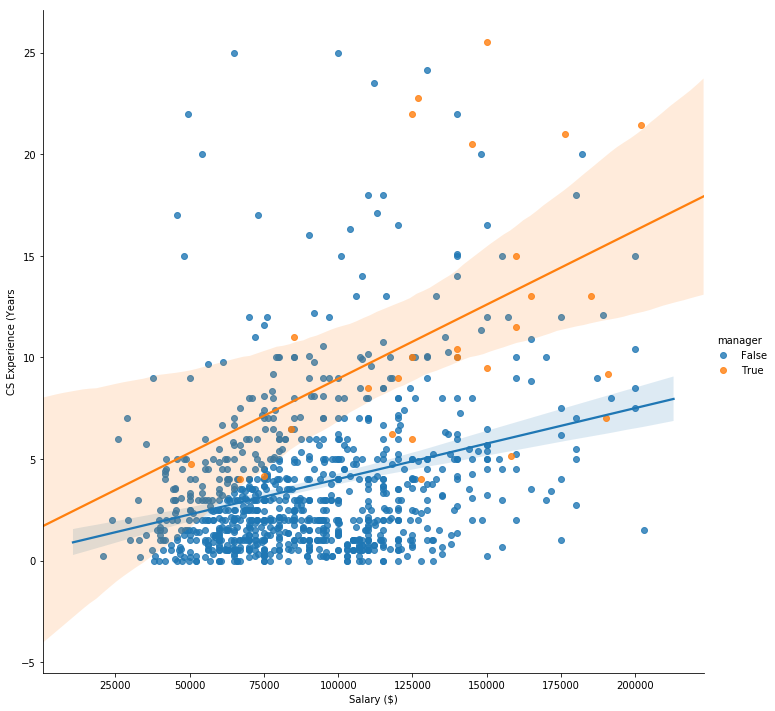

In [13]:
g = sns.lmplot(x="base_salary", y="cs_experience", hue="manager",
               truncate=False, size=10, data=base_salary)

g.set_axis_labels("Salary ($)", "CS Experience (Years")

In [14]:
base_salary.manager[base_salary.manager == True].count() / base_salary.manager.count()

0.029094827586206896

In [15]:
base_salary.base_salary[base_salary.manager == True].mean()

135248.14814814815

At 3%, managers are a very small subset of the survey, however experience matters more in terms of salary for them. This experience gap however is compensated by a ~45k average increase in salary.

## Gender

In [16]:
# Look at Gender

base_salary = pd.concat([base_salary, data.gender], join='inner', axis=1)

# fix nonbinary
base_salary.gender[base_salary.gender == 'Nonbinary'] = 'Non-binary'

base_salary.head()

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,job_title_best_fit,all_experience,cs_experience,base_salary,currency_unit,manager,gender
0,Developer/Engineering Generalist,0.500,0.500,84000.000,USD - $,False,Male
1,Developer/Engineering Generalist,6.000,5.000,130000.000,USD - $,False,Female
2,Developer/Engineering Generalist,7.000,2.500,108000.000,USD - $,False,Male
3,Systems Administrator (SysAdmin),2.000,2.000,45760.000,USD - $,False,Male
4,Mobile app developer/Mobile app engineer,4.500,3.667,75000.000,USD - $,False,Male


In [17]:
print("Male:", base_salary.gender[base_salary.gender == 'Male'].count(), "Female:", base_salary.gender[base_salary.gender == 'Female'].count(), "Non-binary:", base_salary.gender[base_salary.gender == 'Non-binary'].count(), "Gender Queer:", base_salary.gender[base_salary.gender == 'gender queer'].count())

Male: 779 Female: 102 Non-binary: 2 Gender Queer: 1


In [18]:
print("Male:", base_salary.base_salary[base_salary.gender == 'Male'].mean(), "Female:", base_salary.base_salary[base_salary.gender == 'Female'].mean(), "Non-binary:", base_salary.base_salary[base_salary.gender == 'Non-binary'].mean(), "Gender Queer:", base_salary.base_salary[base_salary.gender == 'gender queer'].mean())

Male: 91757.17133504493 Female: 87436.96215686275 Non-binary: 69728.0 Gender Queer: 65000.0


/usr/local/lib/python3.7/site-packages/seaborn/regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


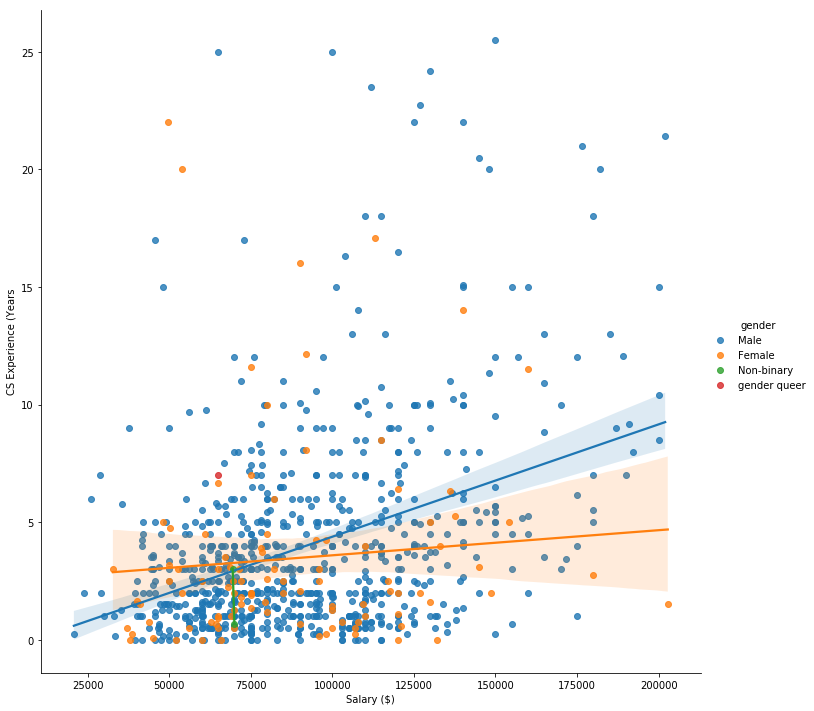

In [19]:
g = sns.lmplot(x="base_salary", y="cs_experience", hue="gender",
               truncate=True, size=10, fit_reg=True, data=base_salary)

g.set_axis_labels("Salary ($)", "CS Experience (Years")